# Fine Tune Deep Learning Model

In diesem Notebook wird ein Deep Learning Model auf die Quelldaten angewendet.

## Table of Contents

# Imports

In [15]:
import pandas as pd
import numpy as np
import os
import tensorflow as tf

# Preprocessing
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import nltk

# Preprocess features
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
nltk.download('stopwords')

# Preprocess targets
from sklearn.preprocessing import MinMaxScaler

#LSTM for regression
from keras.models import Sequential
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, concatenate
from tensorflow.keras.models import Model
import keras.optimizers
from tensorflow.keras.callbacks import EarlyStopping

# Evaluation
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error

# Visulization
from tensorflow.keras.utils import plot_model
import matplotlib.pyplot as plt

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/leamayer/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Data Loading

Zunächst wird das kanadische Youtube-Datenset aus dem Jahr 2012 als das Zieldatenset für dieses Projekt festgelegt. Anschließend werden die textuellen Attribute der Videos als Features und die Views der Videos als Target ausgewählt. 

In [16]:
# Select Target Dataset

target_file = "CAvideos_12.csv"

df_target = pd.read_csv("../Data/processed_data/"+target_file)
df_target = df_target.dropna()

df_target = df_target [["channel_title","tags","description", "title","views"]]

df_target["views"] = df_target["views"].astype(int)

print(f">>> Created target df ({len(df_target)})")

>>> Created target df (6039)


In [17]:
# Loas features and targets

feature_df = df_target [["channel_title","tags","title","description"]]  # Text data as numpy list
targets = df_target["views"].to_numpy()  # Target data as numpy list


## Preprocessing

### Normalize Targets

Die Normalisierung der Zieldaten verbesser die Vergleichbarkeit, Interpretierbarkeit, Konsistenz und Stabilität der Vorhersage. Dafür wird im folgenden der Min-Max Scaler der Sklearn Bibliothek verwendet.

In [18]:
# Normalizing the target values with the min-max normalization

scaler = MinMaxScaler()
normalized_targets = scaler.fit_transform(targets.reshape(-1, 1)).flatten()

print(f">>> Range from original targets ({targets.min()};{targets.max()}) has been normalized ({normalized_targets.min()};{normalized_targets.max()})")

>>> Range from original targets (1295;137843120) has been normalized (0.0;1.0)


### Apply Stemmer and Remove Stopwords from Text Features

Um Wörter derselben Wortfamilie auf eine gemeinsame Stamm zurückführen, wird im Folgenden ein ***Stemmer*** auf die Features angewendet. Im Gegensatz zu einem Lemmatisierer, der die Wörter auf ihre Grundform reduziert, ist der Stemmer wesentlich schneller, da nur die Wortendungen entfernt werden. Dies kann zu grammatikalisch inkonsistenten Sätzen führen, was aber bei dieser Aufgabe zu vernachlässigen ist.

Des weiteren werden semantisch ***unwichtige Wörter*** (die häufig vorkommen) entfernt. Dabei wird auf die nlkt English-Stopwords-Liste zurückgegriffen. Um noch weitere Youtube-spezifische Stowords zu indentifizieren. Werden für jedes Feature 250 weitere Stopwords mithilfe des Tfidf-Scores identifiziert und zu den nlkt Stopwords hinzugefügt. Dieser Score sagt aus, ob ein Wort über alle Youtubevideos hinweg oft vorkommt und dementsprechend semmantisch unwichtig ist.

In [19]:
# Add content speficic stopwords by select the top N words with the highest TF-IDF scores as potential stopwords

def get_content_stopwords(texts):
    
    vectorizer = TfidfVectorizer() # TfidfVectorizer object from sklearn

    tfidf_matrix = vectorizer.fit_transform(texts) 

    feature_names = vectorizer.get_feature_names_out()

    avg_tfidf_scores = tfidf_matrix.mean(axis=0).tolist()[0] # Get average TF-IDF score for each word

    word_scores = list(zip(feature_names, avg_tfidf_scores))

    word_scores.sort(key=lambda x: x[1], reverse=True) # Sort the word_scores in descending order

    N = 250 # Number of stopwords to select
    stopwords_content = [word for word, score in word_scores[:N]] # Potential stopwords

    print(f">>> {len(stopwords_content)} content specific stopwords are identified")

    return stopwords_content

In [20]:
# Define stemmer and stopwords

def get_stopwords(texts):

    # Stopwords
    stop_words_nlkt = set(stopwords.words('english'))

    # add contect speficic stopwords 
    original_stopword_len = len(stop_words_nlkt)

    stop_words = stop_words_nlkt.copy()

    stop_words |= set(get_content_stopwords(texts)) # Add the additional wikipedia specific stopwords

    merged_stopword_len = len(stop_words)

    print(f">>> {merged_stopword_len-original_stopword_len} additional stopwords have been added to the nlkt stopwords list")

    return stop_words

In [21]:
# Apply Stemmer and Stopword removal

# Get Stemmer
stemmer = SnowballStemmer('english')
feature_df_preprocessed = pd.DataFrame()


for feature in feature_df:

    print(f"\n--- Preprocessing {feature} feature ---\n")

    texts = feature_df[feature].to_numpy()

    # Remove numbers and singel characters

    texts_preprocessed = [' '.join([word for word in text.split() if not word.isnumeric()]) for text in texts] # Remove numbers
    texts_preprocessed = [' '.join([word for word in text.split() if not len(word) > 1]) for text in texts] # Remove words with one character

    print(">>> Numbers and words with only one character are removed")

    # Get Stopwords
    stop_words = get_stopwords(texts)

    # Remove stop words from the text data and apply stemmer

    texts_preprocessed = [' '.join([stemmer.stem(word) for word in text.split() if word.lower() not in stop_words]) for text in texts]

    feature_df_preprocessed[feature] = texts_preprocessed

    print(">>> The Stemmer and the Stopword Removal are applied f.e.:\n")

    print (texts[5]) # show example
    print (texts_preprocessed[5])


--- Preprocessing channel_title feature ---

>>> Numbers and words with only one character are removed
>>> 250 content specific stopwords are identified
>>> 243 additional stopwords have been added to the nlkt stopwords list
>>> The Stemmer and the Stopword Removal are applied f.e.:

Snapchat
snapchat

--- Preprocessing tags feature ---

>>> Numbers and words with only one character are removed


>>> 250 content specific stopwords are identified
>>> 230 additional stopwords have been added to the nlkt stopwords list
>>> The Stemmer and the Stopword Removal are applied f.e.:

new snapchat|"version 2"|"snap inc"|"brandnew"|"update"|"software"|"snap"|"new update"|"redesign"|"reorganize"|"Snapchat"
snapchat|"vers 2"|"snap inc"|"brandnew"|"update"|"software"|"snap"|"new update"|"redesign"|"reorganize"|"snapchat"

--- Preprocessing title feature ---

>>> Numbers and words with only one character are removed
>>> 250 content specific stopwords are identified
>>> 194 additional stopwords have been added to the nlkt stopwords list
>>> The Stemmer and the Stopword Removal are applied f.e.:

The New Snapchat in 60 Seconds
snapchat 60 second

--- Preprocessing description feature ---

>>> Numbers and words with only one character are removed
>>> 250 content specific stopwords are identified
>>> 181 additional stopwords have been added to the nlkt stopwords list
>>> The Stemmer and the Stopw

### Tokenize and Split the Text Data

Im Folgenden sollen aus den Text Features, Features entstehen, die in einem Modell verarbeitet werden können.
Dazu wird der ***Text in Sequencen*** übertragen. 

Hierfür wird zunächst ein Tokenizer angewendet um den Text in einzelne Wörter zu verlegen. Anschliend werden diese in Zahlen Sequence umgeschrieben und je eine Zahl als Spalte im Dataframe gespeichert. Anschließend werden die Features jeweils in ***Train-Validation-Test Datensätze*** aufgeteilt, da jedes Text-Feature im NN über einen eigenen Input verarbeitet werden muss.

In [22]:
# Tokenize the text data
def tokenize (texts):
    
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(texts)
    sequences = tokenizer.texts_to_sequences(texts)

    # Vocabulary size
    vocab_size = len(tokenizer.word_index) + 1

    # Pad sequences to a fixed length
    max_sequence_length = 100
    padded_sequences = pad_sequences(sequences, maxlen=max_sequence_length)

    return padded_sequences, vocab_size, max_sequence_length

In [23]:
# Split the data into training and validation sets
def train_val_test_split(padded_sequences):
    
    train_texts, val_texts = train_test_split( padded_sequences, test_size=0.2, random_state=42) # train-validation split with validation size of 20%
    train_texts, test_texts = train_test_split( train_texts, test_size=0.125, random_state=42) # train-test split with test size of 10%

    print(f">>> Text shape train: {train_texts.shape} val: {val_texts.shape} test: {test_texts.shape}")

    return train_texts, val_texts, test_texts

In [24]:

# Split target data

print(f"\n--- Splitting Target Data ---\n")

train_targets, val_targets = train_test_split( normalized_targets, test_size=0.2, random_state=42) # train-validation split with validation size of 20%
train_targets, test_targets = train_test_split( train_targets, test_size=0.125, random_state=42) # train-test split with test size of 10%
print(f">>> Target shape train: {train_targets.shape} val: {val_targets.shape} test: {test_targets.shape}")


# Split feature data featurewise

split_names = ["train_texts", "val_texts", "test_texts"]
vocab_list = []

for feature in feature_df_preprocessed:
    
    print(f"\n--- Tokenizing and Splitting {feature} feature ---\n")

    texts = feature_df_preprocessed[feature].to_numpy()

    return_values = tokenize(texts)

    padded_sequences = return_values[0]

    vocab_list.append(return_values[1])

    max_sequence_length = return_values[2]

    feature_df_preprocessed[feature] = padded_sequences

    split_list = train_val_test_split(padded_sequences)

    iterator = 0

    print(f">>> The Feature Splits are saved under the following names:")

    for split in split_list:
        variable_name = split_names[iterator]+"_"+feature
        print(variable_name)
        exec(variable_name + " = split")
        iterator+=1


--- Splitting Target Data ---

>>> Target shape train: (4227,) val: (1208,) test: (604,)

--- Tokenizing and Splitting channel_title feature ---

>>> Text shape train: (4227, 100) val: (1208, 100) test: (604, 100)
>>> The Feature Splits are saved under the following names:
train_texts_channel_title
val_texts_channel_title
test_texts_channel_title

--- Tokenizing and Splitting tags feature ---

>>> Text shape train: (4227, 100) val: (1208, 100) test: (604, 100)
>>> The Feature Splits are saved under the following names:
train_texts_tags
val_texts_tags
test_texts_tags

--- Tokenizing and Splitting title feature ---

>>> Text shape train: (4227, 100) val: (1208, 100) test: (604, 100)
>>> The Feature Splits are saved under the following names:
train_texts_title
val_texts_title
test_texts_title

--- Tokenizing and Splitting description feature ---

>>> Text shape train: (4227, 100) val: (1208, 100) test: (604, 100)
>>> The Feature Splits are saved under the following names:
train_texts_des

# Model Training

Keras ist in der Lage, über seine funktionale API mehrere Eingaben zu verarbeiten.

https://keras.io/guides/functional_api/
https://pyimagesearch.com/2019/02/04/keras-multiple-inputs-and-mixed-data/
https://neptune.ai/blog/transfer-learning-guide-examples-for-images-and-text-in-keras#:~:text=%60include_top%3DFalse%60%20means%20that,is%20important%20for%20feature%20extraction (An diesen Beispielen wird sich im Folgenden orientiert)

Ein Modell mit mehreres Features als Input wurde im vorherigen Notebook vortrainiert. Dieses Modell wird hier verwendet und auf die Zieldaten gefinetund.

## Use Pretrained Model

Zunächst wird das vortrainierte Modell und desser Gewichte geladen. Anschließend werden die Layers des Pretrainedmodells eingefroren, damit diese während des Trainingsprozesses nicht aktualisiert und das Gelernte überschrieben wird `model_pretrain.trainable = False`. Durch `include_top=False` wird die letzte Dense Layer des vortrainierten Modells übernommen. Diese Outputlayer wird neu definiert und dementsprechend spezifisch auf die Zieldaten trainiert. Beim Training wird anschließend nur die letzte Schicht trainiert. Dementsprechend fängt der Loss schon reduziert an. 

In [37]:
model_pretrain = tf.keras.models.load_model('source_lstm_model.h5')
model_pretrain.load_weights('source_lstm_model_weights.h5')
model_pretrain.summary()

model_pretrain.include_top = False
model_pretrain.trainable = False

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_13 (InputLayer)          [(None, 100)]        0           []                               
                                                                                                  
 input_14 (InputLayer)          [(None, 100)]        0           []                               
                                                                                                  
 input_15 (InputLayer)          [(None, 100)]        0           []                               
                                                                                                  
 input_16 (InputLayer)          [(None, 100)]        0           []                               
                                                                                            

In [38]:
input1 = Input(shape=(max_sequence_length,))
input2 = Input(shape=(max_sequence_length,))
input3 = Input(shape=(max_sequence_length,))
input4 = Input(shape=(max_sequence_length,))

#x = Flatten(name='flatten')(model_pretrain)
x = model_pretrain(inputs=[input1, input2, input3, input4], training=False)
x = Dense(1, activation='linear')(x)

# Create Transfer Model
transfer_model = Model(inputs=[input1, input2, input3, input4], outputs=x)
transfer_model.compile(loss='mean_squared_error', optimizer='adam')

transfer_model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_13 (InputLayer)          [(None, 100)]        0           []                               
                                                                                                  
 input_14 (InputLayer)          [(None, 100)]        0           []                               
                                                                                                  
 input_15 (InputLayer)          [(None, 100)]        0           []                               
                                                                                                  
 input_16 (InputLayer)          [(None, 100)]        0           []                               
                                                                                            

In [39]:
callbacks = [
            EarlyStopping(patience = 10)
            ]

In [40]:
# Train the model
batch_size = 32
epochs = 10
history_transfer_model = transfer_model.fit([train_texts_channel_title, train_texts_tags, train_texts_description, train_texts_title],
                                   train_targets,
                                   batch_size=batch_size,
                                   epochs=epochs,
                                   validation_data=([val_texts_channel_title, val_texts_tags, val_texts_description, val_texts_title], val_targets), 
                                   callbacks=callbacks)

Epoch 1/10


133/133 [==============================] - 9s 39ms/step - loss: 0.0016 - val_loss: 0.0012
Epoch 2/10
133/133 [==============================] - 4s 30ms/step - loss: 0.0016 - val_loss: 0.0012
Epoch 3/10
133/133 [==============================] - 4s 29ms/step - loss: 0.0016 - val_loss: 0.0012
Epoch 4/10
133/133 [==============================] - 4s 31ms/step - loss: 0.0016 - val_loss: 0.0011
Epoch 5/10
133/133 [==============================] - 4s 29ms/step - loss: 0.0016 - val_loss: 0.0011
Epoch 6/10
133/133 [==============================] - 4s 33ms/step - loss: 0.0016 - val_loss: 0.0011
Epoch 7/10
133/133 [==============================] - 4s 31ms/step - loss: 0.0015 - val_loss: 0.0011
Epoch 8/10
133/133 [==============================] - 4s 30ms/step - loss: 0.0015 - val_loss: 0.0011
Epoch 9/10
133/133 [==============================] - 4s 29ms/step - loss: 0.0015 - val_loss: 0.0011
Epoch 10/10
133/133 [==============================] - 4s 30ms/step - loss: 0.0015 - val_loss: 0.0011


## Fine Tuning the model
Um das Modell noch weiter zu verbessern Modell, können die eingefrorenen Layers wieder aufgetaut werden und mit einer sehr niedrigen Lernrate neu trainiert werden. Im folgenden werden dafür mehrere Lernraten ausprobiert. (1e-4,1e-5)

In [41]:
model_pretrain.trainable = True

input1 = Input(shape=(max_sequence_length,))
input2 = Input(shape=(max_sequence_length,))
input3 = Input(shape=(max_sequence_length,))
input4 = Input(shape=(max_sequence_length,))

#x = Flatten(name='flatten')(model_pretrain)
x = model_pretrain(inputs=[input1, input2, input3, input4], training=False)
x = Dense(1, activation='linear')(x)

# Fine tuned Model 

fine_tuned_model = Model(inputs=[input1, input2, input3, input4], outputs=x)

fine_tuned_model.compile(loss='mean_squared_error', optimizer=keras.optimizers.Adam(1e-4))

fine_tuned_model.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_17 (InputLayer)          [(None, 100)]        0           []                               
                                                                                                  
 input_18 (InputLayer)          [(None, 100)]        0           []                               
                                                                                                  
 input_19 (InputLayer)          [(None, 100)]        0           []                               
                                                                                                  
 input_20 (InputLayer)          [(None, 100)]        0           []                               
                                                                                            

In [42]:
# Train the model
batch_size = 32
epochs = 10

history_fine_tuning = fine_tuned_model.fit([train_texts_channel_title, train_texts_tags, train_texts_description, train_texts_title],
                                   train_targets,
                                   batch_size=batch_size,
                                   epochs=epochs,
                                   validation_data=([val_texts_channel_title, val_texts_tags, val_texts_description, val_texts_title], val_targets), 
                                   callbacks=callbacks)

Epoch 1/10


133/133 [==============================] - 21s 121ms/step - loss: 0.0015 - val_loss: 0.0010
Epoch 2/10
133/133 [==============================] - 15s 112ms/step - loss: 0.0014 - val_loss: 9.9915e-04
Epoch 3/10
133/133 [==============================] - 15s 111ms/step - loss: 0.0014 - val_loss: 9.5142e-04
Epoch 4/10
133/133 [==============================] - 15s 111ms/step - loss: 0.0012 - val_loss: 8.5217e-04
Epoch 5/10
133/133 [==============================] - 15s 112ms/step - loss: 0.0010 - val_loss: 7.3150e-04
Epoch 6/10
133/133 [==============================] - 15s 112ms/step - loss: 7.6464e-04 - val_loss: 5.4634e-04
Epoch 7/10
133/133 [==============================] - 15s 114ms/step - loss: 4.3958e-04 - val_loss: 4.0262e-04
Epoch 8/10
133/133 [==============================] - 15s 112ms/step - loss: 2.8173e-04 - val_loss: 3.3048e-04
Epoch 9/10
133/133 [==============================] - 17s 125ms/step - loss: 2.5284e-04 - val_loss: 3.3748e-04
Epoch 10/10
133/133 [===============

# Model Evaluation

## Evaluatie Loss

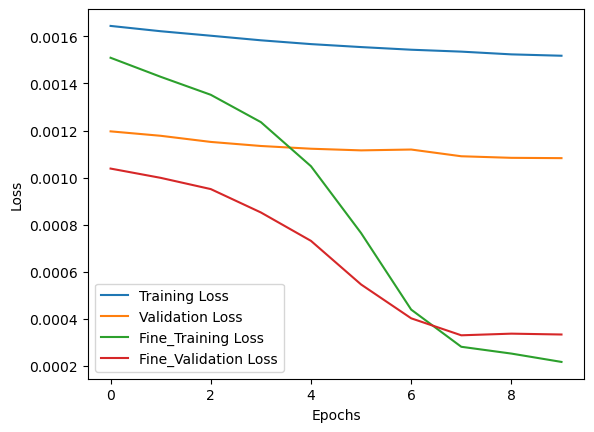

In [43]:
# Plot training and validation loss

# Plot the loss values
plt.plot(history_transfer_model.history['loss'], label='Training Loss')
plt.plot(history_transfer_model.history['val_loss'], label='Validation Loss')
plt.plot(history_fine_tuning.history['loss'], label='Fine_Training Loss')
plt.plot(history_fine_tuning.history['val_loss'], label='Fine_Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Prediction

In [45]:
# Make predictions
pred = transfer_model.predict([test_texts_channel_title,test_texts_tags, test_texts_description, test_texts_title])

# Convert normalized predictions back to original scale
original_pred = scaler.inverse_transform(pred.reshape(-1, 1)).flatten()
original_targets = scaler.inverse_transform(test_targets.reshape(-1, 1)).flatten()

# Evaluation metrics
mse_transfer = mean_squared_error(original_targets, original_pred)
mape_transfer = mean_absolute_percentage_error(original_targets, original_pred)
rmse_transfer = np.sqrt(mse_transfer)
print("Mean Squared Error (MSE):", mse_transfer)
print("Mean Absolute Percentage Error (MAPE):", mape_transfer)
print("Root Mean Squared Error (RMSE):", rmse_transfer)

19/19 [==============================] - 1s 21ms/step
Mean Squared Error (MSE): 13992969455747.56
Mean Absolute Percentage Error (MAPE): 9.217626698802647
Root Mean Squared Error (RMSE): 3740717.772800771


In [46]:
# Make predictions
pred = fine_tuned_model.predict([test_texts_channel_title,test_texts_tags, test_texts_description, test_texts_title])

# Convert normalized predictions back to original scale
original_pred_fine = scaler.inverse_transform(pred.reshape(-1, 1)).flatten()
original_targets = scaler.inverse_transform(test_targets.reshape(-1, 1)).flatten()

# Evaluation metrics
mse_fine = mean_squared_error(original_targets, original_pred)
mape_fine = mean_absolute_percentage_error(original_targets, original_pred)
rmse_fine = np.sqrt(mse_fine)
print("Mean Squared Error (MSE):", mse_fine)
print("Mean Absolute Percentage Error (MAPE):", mape_fine)
print("Root Mean Squared Error (RMSE):", rmse_fine)

19/19 [==============================] - 1s 25ms/step
Mean Squared Error (MSE): 13992969455747.56
Mean Absolute Percentage Error (MAPE): 9.217626698802647
Root Mean Squared Error (RMSE): 3740717.772800771


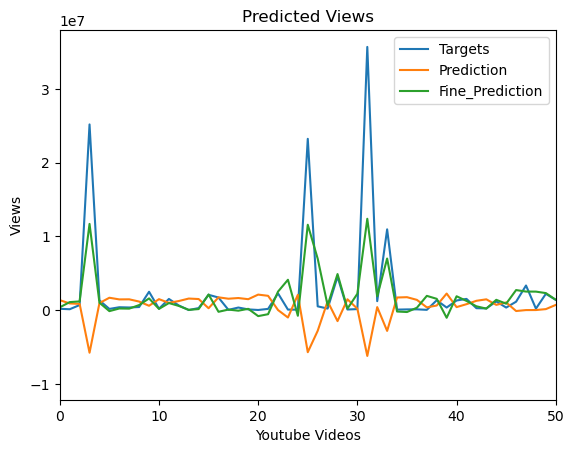

In [47]:
# Plotting
plt.plot(original_targets, label='Targets')
plt.plot(original_pred, label='Prediction')
plt.plot(original_pred_fine, label='Fine_Prediction')

# Add labels and title
plt.xlabel('Youtube Videos')
plt.ylabel('Views')
plt.title('Predicted Views')
plt.xlim((0, 50))

# Add legend
plt.legend()

# Show the plot
plt.show()

## Singel input benchmark

Als Benchmark wird hier noch ein Modell ohne das Vortrainierte Modell alleine basierend auf den Zieldaten trainiert.

In [49]:
# Define the LSTM model with three text inputs
input1 = Input(shape=(max_sequence_length,))
input2 = Input(shape=(max_sequence_length,))
input3 = Input(shape=(max_sequence_length,))
input4 = Input(shape=(max_sequence_length,))

# Define layers
embedding = Embedding(sum(vocab_list), 100)
lstm = LSTM(64)
dense = Dense(1, activation='linear')

# Apply Layers to input
embedded1 = embedding(input1)
embedded2 = embedding(input2)
embedded3 = embedding(input3)
embedded4 = embedding(input4)
lstm1 = lstm(embedded1)
lstm2 = lstm(embedded2)
lstm3 = lstm(embedded3)
lstm4 = lstm(embedded4)
concatenated = concatenate([lstm1, lstm2, lstm3, lstm4])
output = dense(concatenated)

benchmark_model = Model(inputs=[input1, input2, input3, input4], outputs=output)
benchmark_model.compile(loss='mean_squared_error', optimizer='adam')

benchmark_model.summary()

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_24 (InputLayer)          [(None, 100)]        0           []                               
                                                                                                  
 input_25 (InputLayer)          [(None, 100)]        0           []                               
                                                                                                  
 input_26 (InputLayer)          [(None, 100)]        0           []                               
                                                                                                  
 input_27 (InputLayer)          [(None, 100)]        0           []                               
                                                                                            

In [50]:
# Train the model
batch_size = 32
epochs = 10
benchmark_history = benchmark_model.fit([train_texts_channel_title, train_texts_tags, train_texts_description, train_texts_title],
                                   train_targets,
                                   batch_size=batch_size,
                                   epochs=epochs,
                                   validation_data=([val_texts_channel_title, val_texts_tags, val_texts_description, val_texts_title], val_targets), 
                                   callbacks=callbacks)

Epoch 1/10


133/133 [==============================] - 20s 116ms/step - loss: 0.0011 - val_loss: 6.4517e-04
Epoch 2/10
133/133 [==============================] - 15s 110ms/step - loss: 6.3411e-04 - val_loss: 5.0468e-04
Epoch 3/10
133/133 [==============================] - 14s 106ms/step - loss: 4.1633e-04 - val_loss: 3.6962e-04
Epoch 4/10
133/133 [==============================] - 14s 106ms/step - loss: 4.5612e-04 - val_loss: 3.2584e-04
Epoch 5/10
133/133 [==============================] - 15s 112ms/step - loss: 3.4707e-04 - val_loss: 2.4879e-04
Epoch 6/10
133/133 [==============================] - 17s 126ms/step - loss: 2.7134e-04 - val_loss: 2.9425e-04
Epoch 7/10
133/133 [==============================] - 14s 108ms/step - loss: 3.2291e-04 - val_loss: 2.5645e-04
Epoch 8/10
133/133 [==============================] - 15s 110ms/step - loss: 3.2839e-04 - val_loss: 3.0622e-04
Epoch 9/10
133/133 [==============================] - 14s 109ms/step - loss: 2.7997e-04 - val_loss: 3.1717e-04
Epoch 10/10
133/

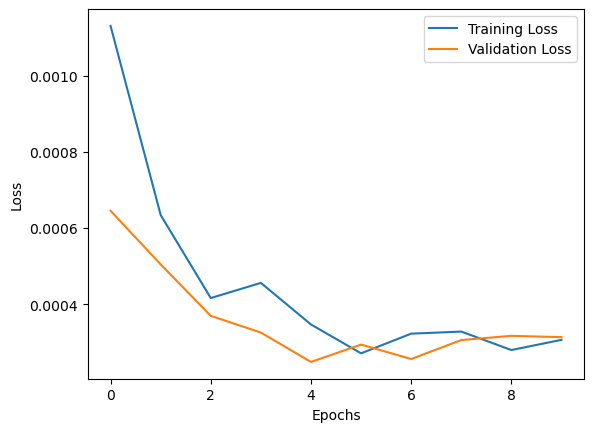

In [51]:
# Plot training and validation loss

# Plot the loss values
plt.plot(benchmark_history.history['loss'], label='Training Loss')
plt.plot(benchmark_history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [52]:
# Make predictions
pred = benchmark_model.predict([test_texts_channel_title,test_texts_tags, test_texts_description, test_texts_title])

# Convert normalized predictions back to original scale
original_pred_bench = scaler.inverse_transform(pred.reshape(-1, 1)).flatten()
original_targets = scaler.inverse_transform(test_targets.reshape(-1, 1)).flatten()

# Evaluation metrics
mse_bench = mean_squared_error(original_targets, original_pred)
mape_bench = mean_absolute_percentage_error(original_targets, original_pred)
rmse_bench = np.sqrt(mse_bench)
print("Mean Squared Error (MSE):", mse_bench)
print("Mean Absolute Percentage Error (MSE):", mape_bench)
print("Root Mean Squared Error (RMSE):", rmse_bench)

19/19 [==============================] - 1s 22ms/step
Mean Squared Error (MSE): 13992969455747.56
Mean Absolute Percentage Error (MSE): 9.217626698802647
Root Mean Squared Error (RMSE): 3740717.772800771


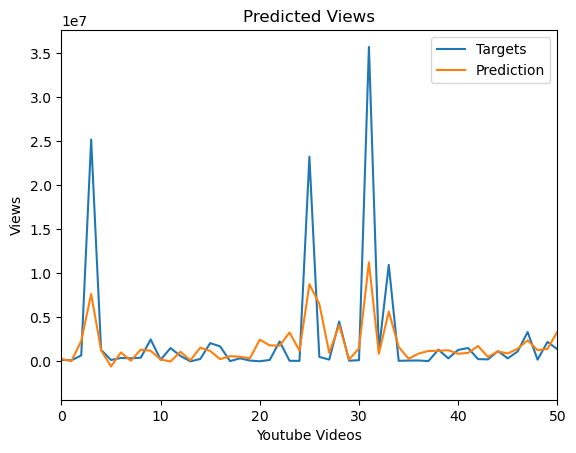

In [53]:
# Plotting
plt.plot(original_targets, label='Targets')
plt.plot(original_pred_bench, label='Prediction')

# Add labels and title
plt.xlabel('Youtube Videos')
plt.ylabel('Views')
plt.title('Predicted Views')
plt.xlim((0, 50))

# Add legend
plt.legend()

# Show the plot
plt.show()

# Comparison

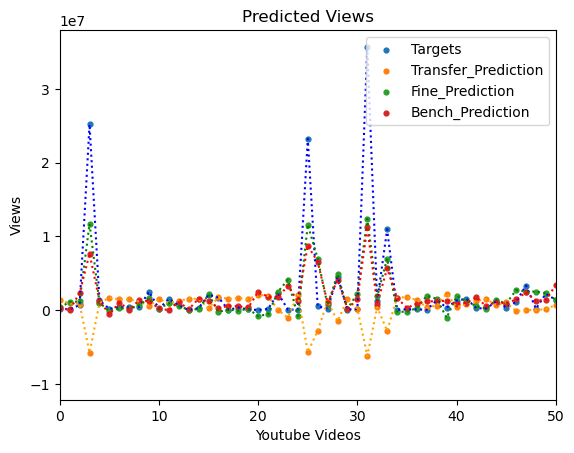

In [54]:
# Scatter plot
plt.scatter(range(len(original_targets)), original_targets, label='Targets', s=12)
plt.scatter(range(len(original_pred)), original_pred, label='Transfer_Prediction', s=12)
plt.scatter(range(len(original_pred_fine)), original_pred_fine, label='Fine_Prediction', s=12)
plt.scatter(range(len(original_pred_bench)), original_pred_bench, label='Bench_Prediction', s=12)

# Dotted lines
plt.plot(range(len(original_targets)), original_targets, linestyle=':', color='blue')
plt.plot(range(len(original_pred)), original_pred, linestyle=':', color='orange')
plt.plot(range(len(original_pred_fine)), original_pred_fine, linestyle=':', color='green')
plt.plot(range(len(original_pred_bench)), original_pred_bench, linestyle=':', color='red')

# Add labels and title
plt.xlabel('Youtube Videos')
plt.ylabel('Views')
plt.title('Predicted Views')
plt.xlim((0, 50))

# Add legend
plt.legend()

# Show the plot
plt.show()

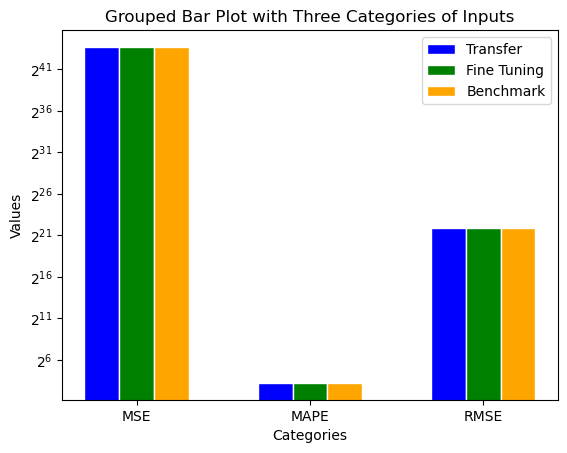

In [60]:
# Show metrics

import numpy as np
import matplotlib.pyplot as plt

# Data for the grouped bar plot
categories = ['MSE', 'MAPE', 'RMSE']
values_1 = [mse_transfer, mape_transfer, rmse_transfer]
values_2 = [mse_fine, mape_fine, rmse_fine]
values_3 = [mse_bench, mape_bench, rmse_bench]

# Set the position of the bars on the x-axis
bar_width = 0.2
r1 = np.arange(len(values_1))
r2 = [x + bar_width for x in r1]
r3 = [x + bar_width for x in r2]

# Creating the grouped bar plot
plt.bar(r1, values_1, color='blue', width=bar_width, edgecolor='white', label='Transfer')
plt.bar(r2, values_2, color='green', width=bar_width, edgecolor='white', label='Fine Tuning')
plt.bar(r3, values_3, color='orange', width=bar_width, edgecolor='white', label='Benchmark')

# Adding labels and title
plt.xlabel('Categories')
plt.ylabel('Values')
plt.title('Grouped Bar Plot with Three Categories of Inputs')

# Adjust the x-axis tick labels
plt.xticks([r + bar_width for r in range(len(values_1))], categories)
plt.yscale('log', base=2)

# Add a legend
plt.legend()

# Displaying the plot
plt.show()
